# Preparation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pwd = os.getcwd()
dataDem = pd.read_csv(f"{pwd}/cleanData/CustomerDemographic.csv")
dataAdd = pd.read_csv(f"{pwd}/cleanData/CustomerAddress.csv")
dataTrn = pd.read_csv(f"{pwd}/cleanData/Transactions.csv")
dataNew = pd.read_csv(f"{pwd}/cleanData/NewCustomerList.csv")

# Data Exploration

## Data Distributions

In [3]:
# Customer Demographic
dataDem = dataDem[dataDem["DOB"].notna()]
dataDem = dataDem.drop(["first_name", "last_name", "job_title", "deceased_indicator"], axis=1)
dataDem.set_index("customer_id", inplace=True)

# Customer Address
dataAdd = dataAdd.drop(["address", "postcode", "country"], axis=1)
dataAdd.set_index("customer_id", inplace=True)

# Transactions
dataTrn = dataTrn[dataTrn["order_status"] != "Cancelled"]
dataTrn = dataTrn[["customer_id", "list_price", "standard_cost"]]

# New Customer List
dataNew = dataNew.drop(["job_title", "deceased_indicator", "address", "postcode", "country", "Rank", "Value"], axis=1)
dataNew["full_name"] = dataNew["first_name"] + " " + dataNew["last_name"]
dataNew = dataNew.set_index("full_name")
dataNew = dataNew.drop(["first_name", "last_name"], axis=1)

## Feature Engineering

In [4]:
# Remove outliers
dataTrn["listVsStandard"] = dataTrn["list_price"] / dataTrn["standard_cost"]
maxTreshold = dataTrn["listVsStandard"].quantile(0.99)
dataTrn = dataTrn[dataTrn["listVsStandard"] < maxTreshold]

# Calculate profit
dataTrn["profit"] = dataTrn["list_price"] - dataTrn["standard_cost"]

# Aggregate rows based on customer IDs
dataTrn = dataTrn.groupby("customer_id").sum()
dataTrn = dataTrn[["profit"]].round(2)

# Join the 3 datasets
df = dataDem.join(dataAdd, on="customer_id", how="inner").join(dataTrn, on="customer_id")
# df = df[df["profit"].notna()]
df["profit"] = df["profit"].fillna(0)
df["entries"] = 1

## Data Transformations

In [5]:
dateDataReceived = "2020-12-18"
timestamp = pd.Timestamp(dateDataReceived)

df["DOB"] = pd.to_datetime(df["DOB"])
df["DOB"] = df["DOB"].where(df["DOB"] < timestamp, df["DOB"] - np.timedelta64(100, "Y"))
df["age"] = (timestamp - df["DOB"]).astype("<m8[Y]")


def toAgeGroup(age):
    if(age < 30):
        return "18-29"
    elif(age < 40):
        return "30-39"
    elif(age < 50):
        return "40-49"
    elif(age < 60):
        return "50-59"
    else:
        return "60+"

def toPastPurchasesGroups(pastPurchases):
    if(pastPurchases < 10):
        return "0-9"
    elif(pastPurchases < 20):
        return "10-19"
    elif(pastPurchases < 30):
        return "20-29"
    elif(pastPurchases < 40):
        return "30-39"
    elif(pastPurchases < 50):
        return "40-49"
    elif(pastPurchases < 60):
        return "50-59"
    elif(pastPurchases < 70):
        return "60-69"
    elif(pastPurchases < 80):
        return "70-79"
    elif(pastPurchases < 90):
        return "80-89"
    else:
        return "90-99"

def toTenureGroups(tenure):
    if(tenure < 4):
        return "00-03"
    elif(tenure < 8):
        return "04-07"
    elif(tenure < 12):
        return "08-11"
    elif(tenure < 16):
        return "12-15"
    elif(tenure < 20):
        return "16-19"
    else:
        return "20-22"

df["DOB"] = df["age"].apply(toAgeGroup)
df = df.drop("age", axis=1)

df["past_3_years_bike_related_purchases"] = df["past_3_years_bike_related_purchases"].apply(toPastPurchasesGroups)
df["tenure"] = df["tenure"].apply(toTenureGroups)

df = df.rename_axis(index={"customer_id": "ID"})
df.columns = ["gender", "pastPurchases", "ageGroup", "jobIndustry", "wealthSegment", "ownsCar", "tenure", "state", "propertyValuation", "totalSpent", "entries"]


df.head()

,gender,pastPurchases,ageGroup,jobIndustry,wealthSegment,ownsCar,tenure,state,propertyValuation,totalSpent,entries
ID,,,,,,,,,,,
1,Female,90-99,60+,Health,Mass Customer,Yes,08-11,NSW,10,3018.09,1
2,Male,80-89,40-49,Financial Services,Mass Customer,Yes,16-19,NSW,10,2226.26,1
4,Male,30-39,50-59,IT,Mass Customer,No,04-07,QLD,9,220.57,1
5,Female,50-59,40-49,NaN,Affluent Customer,Yes,08-11,NSW,4,2394.94,1
6,Male,30-39,50-59,Retail,High Net Worth,Yes,12-15,VIC,9,3946.55,1


# Modeling

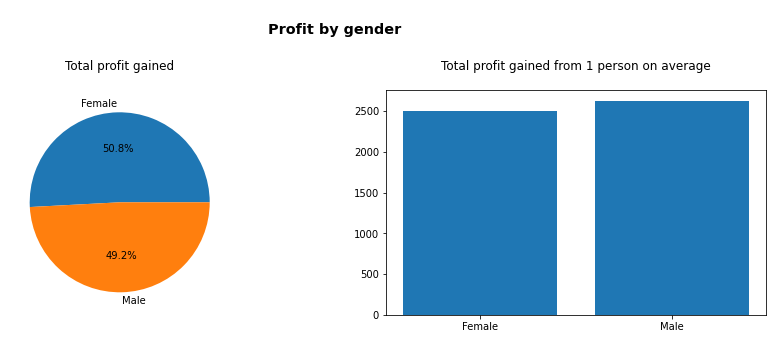

In [6]:
# Gender
gender = df[["gender", "totalSpent", "entries"]]
gender = gender.groupby("gender").sum()
gender["averageSpent"] = gender["totalSpent"] / gender["entries"]

# Plot pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("\nProfit by gender", size="x-large", weight="bold")
fig.subplots_adjust(top=0.75)

# Plot pie chart
ax1.pie(gender["totalSpent"], labels=gender.index, autopct="%.1f%%")
ax1.set_title("Total profit gained", pad=20)

# Plot bar chart
ax2.set_title("Total profit gained from 1 person on average", pad=20)
ax2.bar(gender.index, gender["averageSpent"])

fig.show()

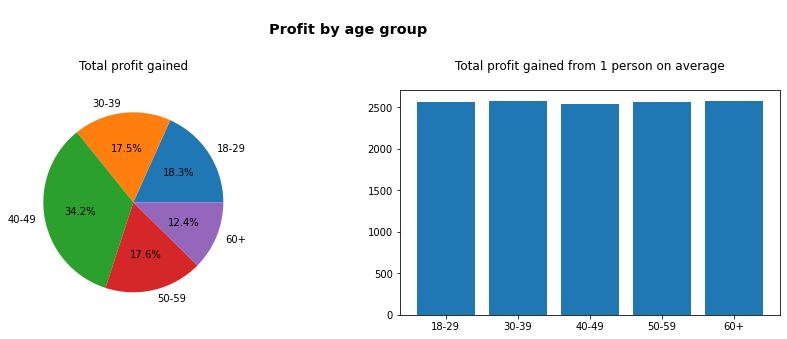

In [7]:
# Age group
ageGroup = df[["ageGroup", "totalSpent", "entries"]]
ageGroup = ageGroup.groupby("ageGroup").sum()
ageGroup["averageSpent"] = ageGroup["totalSpent"] / ageGroup["entries"]

# Plot pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("\nProfit by age group", size="x-large", weight="bold")
fig.subplots_adjust(top=0.75)

# Plot pie chart
ax1.pie(ageGroup["totalSpent"], labels=ageGroup.index, autopct="%.1f%%")
ax1.set_title("Total profit gained", pad=20)

# Plot bar chart
ax2.set_title("Total profit gained from 1 person on average", pad=20)
ax2.bar(ageGroup.index, ageGroup["averageSpent"])

fig.show()

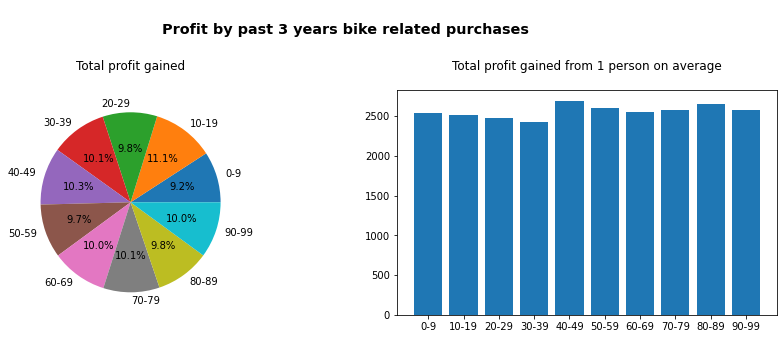

In [8]:
# Past purchases
pastPurchases = df[["pastPurchases", "totalSpent", "entries"]]
pastPurchases = pastPurchases.groupby("pastPurchases").sum()
pastPurchases["averageSpent"] = pastPurchases["totalSpent"] / pastPurchases["entries"]

# Plot pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("\nProfit by past 3 years bike related purchases", size="x-large", weight="bold")
fig.subplots_adjust(top=0.75)

# Plot pie chart
ax1.pie(pastPurchases["totalSpent"], labels=pastPurchases.index, autopct="%.1f%%")
ax1.set_title("Total profit gained", pad=20)

# Plot bar chart
ax2.set_title("Total profit gained from 1 person on average", pad=20)
ax2.bar(pastPurchases.index, pastPurchases["averageSpent"])

fig.show()

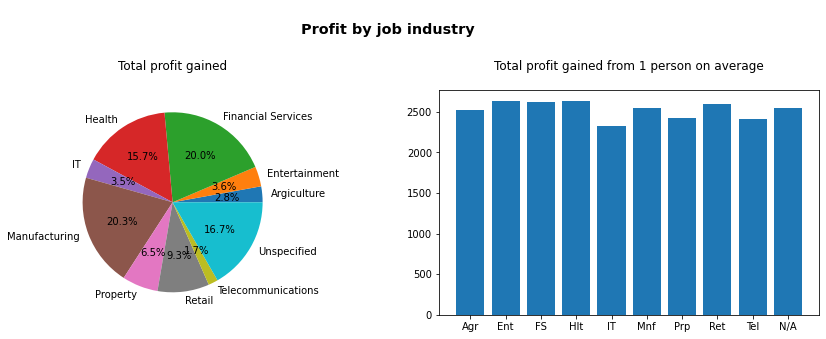

In [9]:
# Job Industry
jobIndustry = df[["jobIndustry", "totalSpent", "entries"]]
jobIndustry["jobIndustry"] = df["jobIndustry"].fillna("Unspecified")
jobIndustry = jobIndustry.groupby("jobIndustry").sum()
jobIndustry["averageSpent"] = jobIndustry["totalSpent"] / jobIndustry["entries"]

# Plot pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("\nProfit by job industry", size="x-large", weight="bold")
fig.subplots_adjust(top=0.75)

# Plot pie chart
ax1.pie(jobIndustry["totalSpent"], labels=jobIndustry.index, autopct="%.1f%%")
ax1.set_title("Total profit gained", pad=20)

# Plot bar chart
ax2.set_title("Total profit gained from 1 person on average", pad=20)
ax2.bar(["Agr", "Ent", "FS", "Hlt", "IT", "Mnf", "Prp", "Ret", "Tel", "N/A"], jobIndustry["averageSpent"])

fig.show()

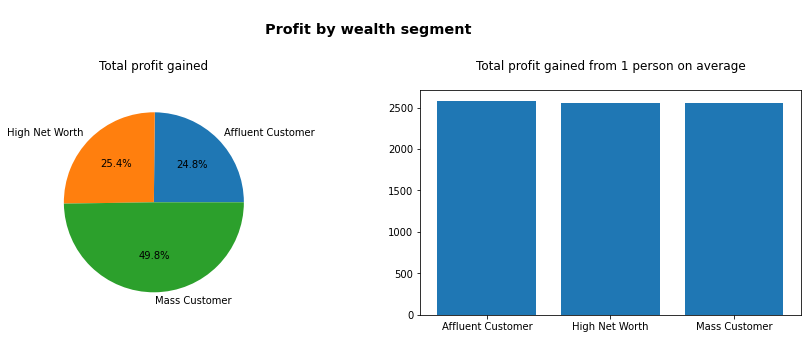

In [11]:
# Wealth segment
wealthSegment = df[["wealthSegment", "totalSpent", "entries"]]
wealthSegment = wealthSegment.groupby("wealthSegment").sum()
wealthSegment["averageSpent"] = wealthSegment["totalSpent"] / wealthSegment["entries"]

# Plot pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("\nProfit by wealth segment", size="x-large", weight="bold")
fig.subplots_adjust(top=0.75)

# Plot pie chart
ax1.pie(wealthSegment["totalSpent"], labels=wealthSegment.index, autopct="%.1f%%")
ax1.set_title("Total profit gained", pad=20)

# Plot bar chart
ax2.set_title("Total profit gained from 1 person on average", pad=20)
ax2.bar(wealthSegment.index, wealthSegment["averageSpent"])

fig.show()

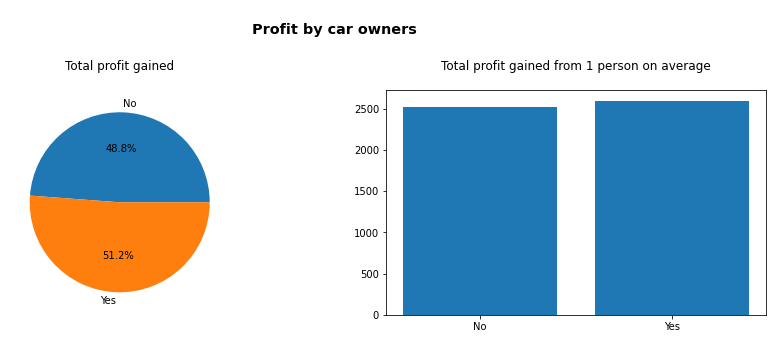

In [12]:
# Owns car
ownsCar = df[["ownsCar", "totalSpent", "entries"]]
ownsCar = ownsCar.groupby("ownsCar").sum()
ownsCar["averageSpent"] = ownsCar["totalSpent"] / ownsCar["entries"]

# Plot pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("\nProfit by car owners", size="x-large", weight="bold")
fig.subplots_adjust(top=0.75)

# Plot pie chart
ax1.pie(ownsCar["totalSpent"], labels=ownsCar.index, autopct="%.1f%%")
ax1.set_title("Total profit gained", pad=20)

# Plot bar chart
ax2.set_title("Total profit gained from 1 person on average", pad=20)
ax2.bar(ownsCar.index, ownsCar["averageSpent"])

fig.show()

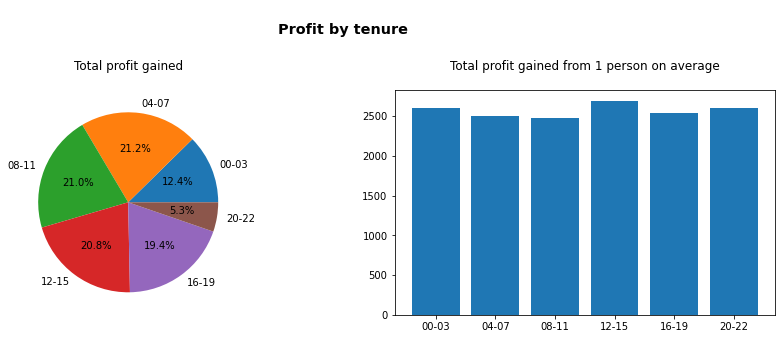

In [13]:
# Tenure
tenure = df[["tenure", "totalSpent", "entries"]]
tenure = tenure.groupby("tenure").sum()
tenure["averageSpent"] = tenure["totalSpent"] / tenure["entries"]

# Plot pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("\nProfit by tenure", size="x-large", weight="bold")
fig.subplots_adjust(top=0.75)

# Plot pie chart
ax1.pie(tenure["totalSpent"], labels=tenure.index, autopct="%.1f%%")
ax1.set_title("Total profit gained", pad=20)

# Plot bar chart
ax2.set_title("Total profit gained from 1 person on average", pad=20)
ax2.bar(tenure.index, tenure["averageSpent"])

fig.show()

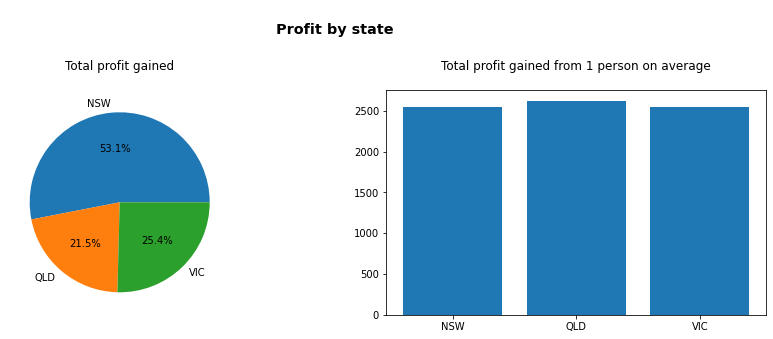

In [14]:
# State
state = df[["state", "totalSpent", "entries"]]
state = state.groupby("state").sum()
state["averageSpent"] = state["totalSpent"] / state["entries"]

# Plot pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("\nProfit by state", size="x-large", weight="bold")
fig.subplots_adjust(top=0.75)

# Plot pie chart
ax1.pie(state["totalSpent"], labels=state.index, autopct="%.1f%%")
ax1.set_title("Total profit gained", pad=20)

# Plot bar chart
ax2.set_title("Total profit gained from 1 person on average", pad=20)
ax2.bar(state.index, state["averageSpent"])

fig.show()

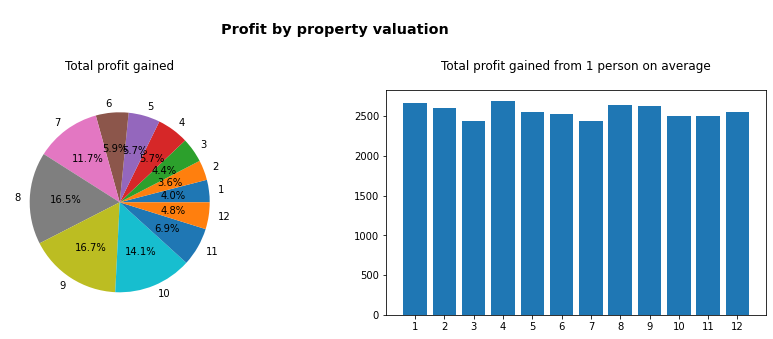

In [16]:
# Property valuation
propertyValuation = df[["propertyValuation", "totalSpent", "entries"]]
propertyValuation = propertyValuation.groupby("propertyValuation").sum()
propertyValuation["averageSpent"] = propertyValuation["totalSpent"] / propertyValuation["entries"]

# Plot pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("\nProfit by property valuation", size="x-large", weight="bold")
fig.subplots_adjust(top=0.75)

# Plot pie chart
ax1.pie(propertyValuation["totalSpent"], labels=propertyValuation.index, autopct="%.1f%%")
ax1.set_title("Total profit gained", pad=20)

# Plot bar chart
ax2.set_title("Total profit gained from 1 person on average", pad=20)
ax2.bar(propertyValuation.index, propertyValuation["averageSpent"])
ax2.set_xticks(propertyValuation.index)

fig.show()